In [483]:
using DataFrames
using RDatasets
using Statistics
using StatsPlots
using CSV
using StatsBase
using NamedArrays
using PrettyTables
using DecisionTree
using Shuffle
using Plots.PlotMeasures
using ScikitLearn.GridSearch: GridSearchCV
using ScikitLearn
using Metrics

include(joinpath(dirname(pwd()), "plottraintest.jl"))


markdowntable (generic function with 1 method)

In [468]:
df = CSV.read(joinpath(dirname(pwd()), "Concrete_Data.csv"), DataFrame)

Row,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Compressive strength (MPa)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
2,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
4,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
5,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.3
6,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.7
8,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
9,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85


In [469]:
dfm = Matrix(df)
dfms = dfm[shuffle(1:end), :]
# dfms = dfm

x = dfms[:, 1:8]
y = dfms[:, 9]

data_split = [0.6, 0.3, 0.1]
split_cs2 = Int.(round.(cumsum(data_split)*length(y)))
split_cs1 = vcat(1, split_cs2[1:(end-1)].+1)

xtrain = x[split_cs1[1]:split_cs2[1], :]
ytrain = y[split_cs1[1]:split_cs2[1]]

xtest = x[split_cs1[2]:split_cs2[2], :]
ytest = y[split_cs1[2]:split_cs2[2]]

xval = x[split_cs1[3]:split_cs2[3], :]
yval = y[split_cs1[3]:split_cs2[3]];

In [470]:
# set of regression parameters and respective default values
# pruning_purity: purity threshold used for post-pruning (default: 1.0, no pruning)
# max_depth: maximum depth of the decision tree (default: -1, no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 5)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)
# n_subfeatures: number of features to select at random (default: 0, keep all)
# keyword rng: the random number generator or seed to use (default Random.GLOBAL_RNG)
n_subfeatures = 0; max_depth = -1; min_samples_leaf = 5
min_samples_split = 2; min_purity_increase = 0.0; pruning_purity = 1.0 ; seed=rand(1:1000)

model = build_tree(ytrain, xtrain,
                   n_subfeatures,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split,
                   min_purity_increase;
                   rng = seed)

Decision Tree
Leaves: 100
Depth:  12

In [471]:
# To avoid overfitting
model = prune_tree(model, 0.9)

Decision Tree
Leaves: 100
Depth:  12

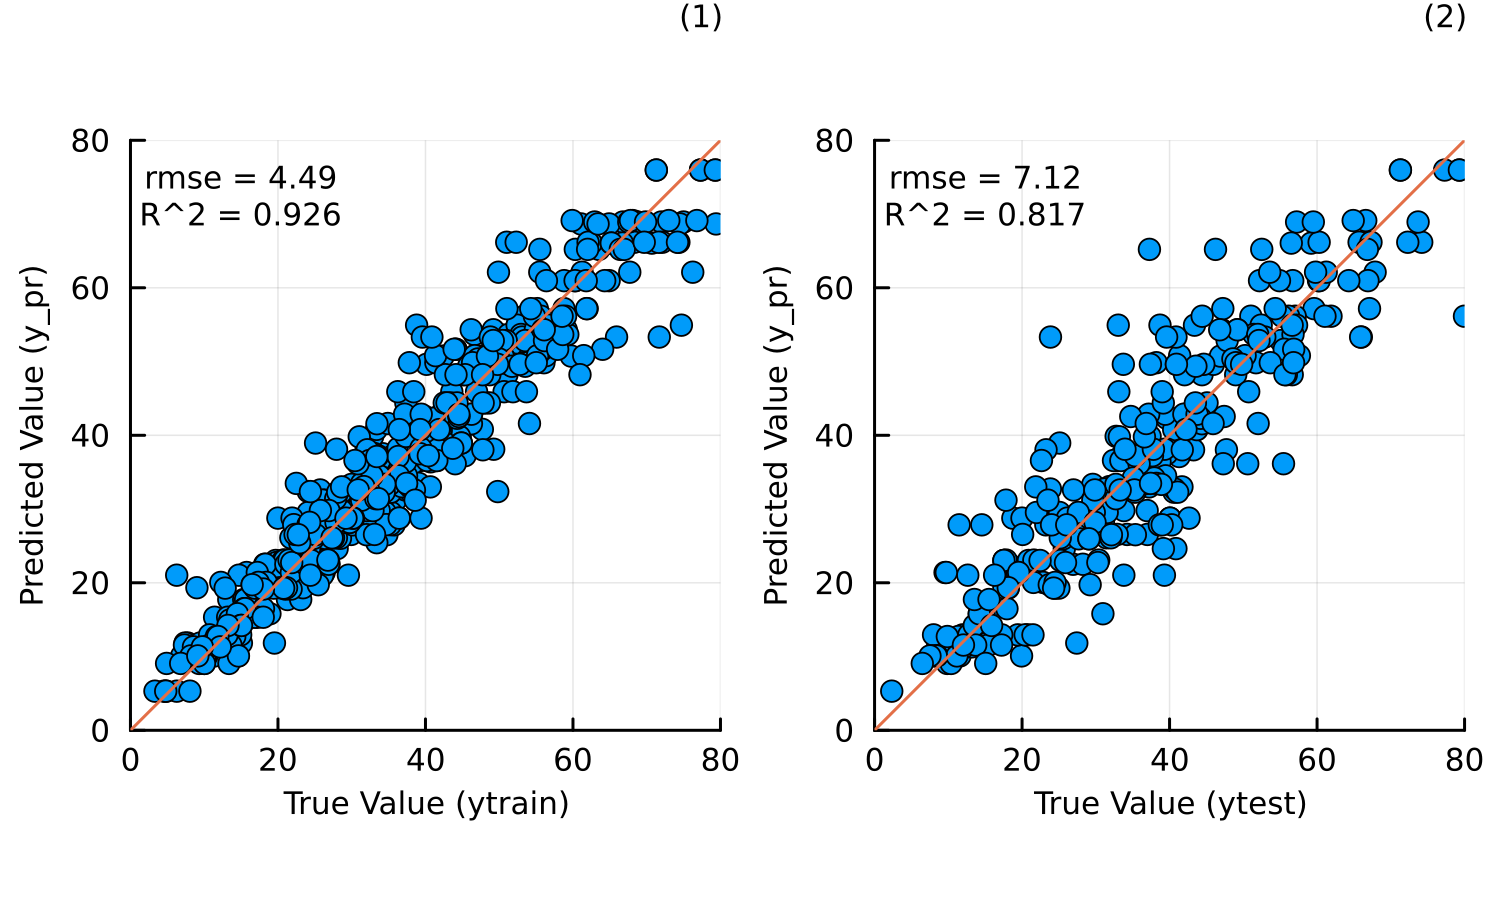

In [472]:
# apply learned model
y_pr_train = apply_tree(model, xtrain)
y_pr_test = apply_tree(model, xtest)

display(plottraintest(ytrain, y_pr_train, ytest, y_pr_test))
savefig(joinpath(dirname(@__FILE__), "Tree.png"))

In [473]:
r2 = nfoldCV_tree(ytrain, xtrain, 3)


Fold 1
Mean Squared Error:     68.82196126590235
Correlation Coeff:      0.8643515076245898
Coeff of Determination: 0.7387214633397509

Fold 2
Mean Squared Error:     72.43754672791239
Correlation Coeff:      0.8494487225503783
Coeff of Determination: 0.7111706730117973

Fold 3
Mean Squared Error:     75.1935882687142
Correlation Coeff:      0.8691067023890544
Coeff of Determination: 0.7524836295662175

Mean Coeff of Determination: 0.7341252553059219


3-element Vector{Float64}:
 0.7387214633397509
 0.7111706730117973
 0.7524836295662175

In [474]:
# set of regression build_forest() parameters and respective default values
# n_subfeatures: number of features to consider at random per split (default: -1, sqrt(# features))
# n_trees: number of trees to train (default: 10)
# partial_sampling: fraction of samples to train each tree on (default: 0.7)
# max_depth: maximum depth of the decision trees (default: no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 5)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)
# keyword rng: the random number generator or seed to use (default Random.GLOBAL_RNG)
#              multi-threaded forests must be seeded with an `Int`
n_subfeatures=-1; n_trees=10; partial_sampling=0.7; max_depth=-1
min_samples_leaf=5; min_samples_split=2; min_purity_increase=0.0; seed=rand(1:1000)
model_forest = build_forest(ytrain, xtrain,
                     n_subfeatures,
                     n_trees,
                     partial_sampling,
                     max_depth,
                     min_samples_leaf,
                     min_samples_split,
                     min_purity_increase;
                     rng = seed)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 68.2
Avg Depth:  10.8

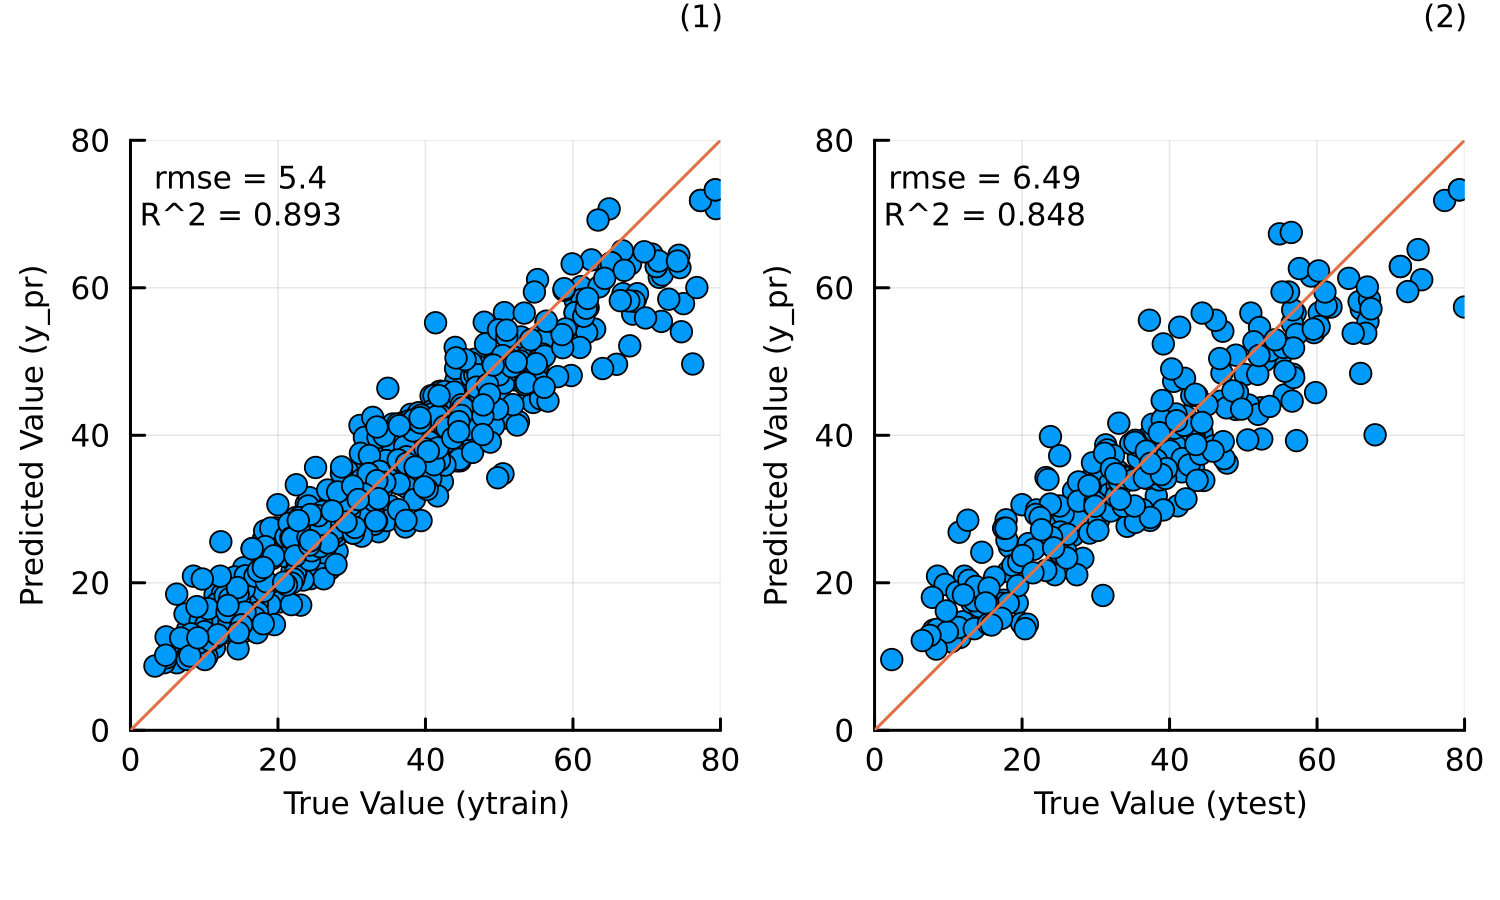

In [475]:
# apply learned model
y_pr_train = apply_forest(model_forest, xtrain)
y_pr_test = apply_forest(model_forest, xtest)

display(plottraintest(ytrain, y_pr_train, ytest, y_pr_test))
savefig(joinpath(dirname(@__FILE__), "Forest.png"))

In [476]:
r2 = nfoldCV_forest(ytrain, xtrain, 3)


Fold 1
Mean Squared Error:     79.34824885834068
Correlation Coeff:      0.860076448184669
Coeff of Determination: 0.7239478626873626

Fold 2
Mean Squared Error:     55.13346923812727
Correlation Coeff:      0.9065989891303202
Coeff of Determination: 0.796695840453997

Fold 3
Mean Squared Error:     64.11829489037932
Correlation Coeff:      0.8736189290173166
Coeff of Determination: 0.7527966979341191

Mean Coeff of Determination: 0.7578134670251595


3-element Vector{Float64}:
 0.7239478626873626
 0.796695840453997
 0.7527966979341191

In [477]:
xmean = mean(x, dims=1)
xstd = std(x, dims=1)

xtrainnorm = (xtrain.-xmean)./xstd
xtestnorm = (xtest.-xmean)./xstd
xvalnorm = (xval.-xmean)./xstd

n_subfeatures = 0; max_depth = -1; min_samples_leaf = 5
min_samples_split = 2; min_purity_increase = 0.0; pruning_purity = 1.0 ; seed=rand(1:1000)

# build tree for normalized values
model_norm = build_tree(ytrain, xtrainnorm,
                   n_subfeatures,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split,
                   min_purity_increase;
                   rng = seed)

Decision Tree
Leaves: 100
Depth:  12

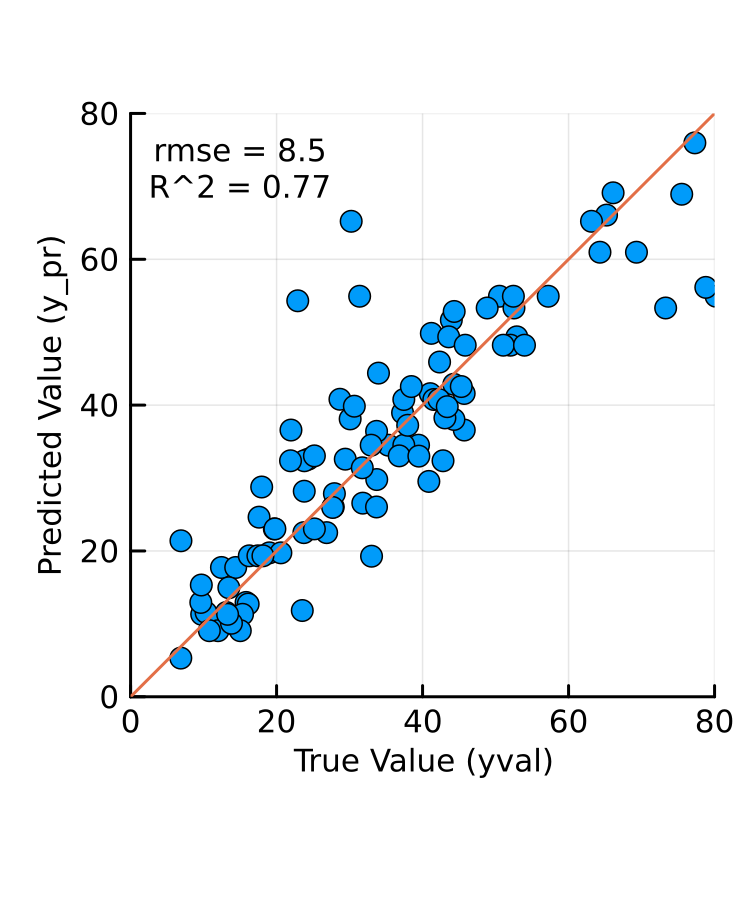

In [478]:
# apply learned model
y_pr_val = apply_tree(model_norm, xvalnorm)

display(plotval(yval, y_pr_val))
savefig(joinpath(dirname(@__FILE__), "TreeVal.png"))

In [479]:
n_subfeatures=-1; n_trees=10; partial_sampling=0.7; max_depth=-1
min_samples_leaf=5; min_samples_split=2; min_purity_increase=0.0; seed=rand(1:1000)
model_forestnorm = build_forest(ytrain, xtrainnorm,
                     n_subfeatures,
                     n_trees,
                     partial_sampling,
                     max_depth,
                     min_samples_leaf,
                     min_samples_split,
                     min_purity_increase;
                     rng = seed)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 67.1
Avg Depth:  10.4

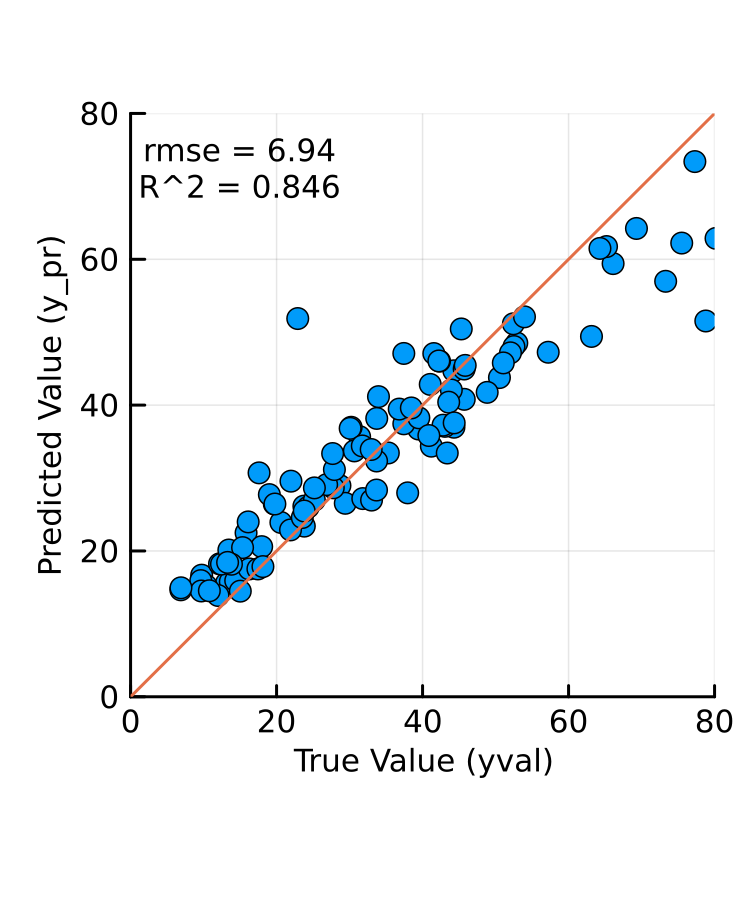

In [480]:
# apply learned model
y_pr_val = apply_forest(model_forestnorm, xvalnorm)

display(plotval(yval, y_pr_val))
savefig(joinpath(dirname(@__FILE__), "ForestVal.png"))

In [481]:
r2 = nfoldCV_forest(ytrain, xtrainnorm, 3)


Fold 1
Mean Squared Error:     73.36089088459708
Correlation Coeff:      0.8988267269944734
Coeff of Determination: 0.7699234748231603

Fold 2
Mean Squared Error:     61.37233486539265
Correlation Coeff:      0.856960509649577
Coeff of Determination: 0.7327275484796938

Fold 3
Mean Squared Error:     71.67592505661915
Correlation Coeff:      0.8598076629939935
Coeff of Determination: 0.7216100168400879

Mean Coeff of Determination: 0.7414203467143139


3-element Vector{Float64}:
 0.7699234748231603
 0.7327275484796938
 0.7216100168400879

In [482]:
param_grid_norm = Dict(:n_trees => 10:1:20)
grid_norm = GridSearchCV(build_forest(), param_grid_norm, refit = true, verbose = 1)

MethodError: MethodError: no method matching build_forest()
Closest candidates are:
  build_forest(!Matched::AbstractVector{T}, !Matched::AbstractMatrix{S}) where {S, T<:Float64} at C:\Users\ray_a\.julia\packages\DecisionTree\Cbrvn\src\regression\main.jl:67
  build_forest(!Matched::AbstractVector{T}, !Matched::AbstractMatrix{S}, !Matched::Any) where {S, T<:Float64} at C:\Users\ray_a\.julia\packages\DecisionTree\Cbrvn\src\regression\main.jl:67
  build_forest(!Matched::AbstractVector{T}, !Matched::AbstractMatrix{S}, !Matched::Any, !Matched::Any) where {S, T<:Float64} at C:\Users\ray_a\.julia\packages\DecisionTree\Cbrvn\src\regression\main.jl:67
  ...

In [487]:
markdowntable(df, "test.md")